LSTM

In [35]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [36]:
acao = 'MGLU3.SA'
periodo_tempo_de_precos_acao = "5y"
ativo = yf.download(acao, period=periodo_tempo_de_precos_acao)

C:\Users\pedro\AppData\Local\Temp\ipykernel_29576\3215143288.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ativo = yf.download(acao, period=periodo_tempo_de_precos_acao)
[*********************100%***********************]  1 of 1 completed


In [37]:
ativo.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-08-05,188.079407,191.319811,187.852810,188.759212,3239949
2020-08-06,194.673508,195.308005,189.212415,190.345428,4712723
2020-08-07,194.084335,198.276463,191.115851,193.064635,4969276
2020-08-10,185.654755,195.557240,183.819283,195.285321,6551488
2020-08-11,183.524719,188.056757,181.802546,187.399606,4561973


In [38]:
# Pega somente o atributo "Close" (preço de fechamento da ação em cada dia) e armazena em um array bidimensional
# O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
ativo_close = ativo['Close'].dropna().to_numpy().reshape(-1, 1)

In [39]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(ativo_close)
data.columns = ['Close']

In [40]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [41]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [42]:
window_size = 60
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [43]:
X[0] # 60 (window-size) valores que ele usa para prever o valor do y. 

array([0.7502584 , 0.77737583, 0.77495293, 0.74028731, 0.7315278 ,
       0.72286135, 0.72649563, 0.73870319, 0.73767811, 0.81083   ,
       0.8126938 , 0.79079477, 0.79079477, 0.78827875, 0.79685196,
       0.81688718, 0.83394047, 0.85816909, 0.84549562, 0.86515818,
       0.84819807, 0.80151132, 0.80402734, 0.79396314, 0.82667184,
       0.79918167, 0.79284487, 0.81828506, 0.81157559, 0.80775488,
       0.78846512, 0.78902422, 0.803375  , 0.81073682, 0.78268748,
       0.80896626, 0.82136019, 0.79191297, 0.79200628, 0.80803437,
       0.83319488, 0.79731787, 0.816794  , 0.80896626, 0.80561159,
       0.83291539, 0.89143696, 0.94595144, 0.9340235 , 0.9276867 ,
       0.93849637, 0.93439623, 0.94744244, 0.95415191, 0.94967891,
       0.94296937, 0.92619576, 0.92545029, 0.89488481, 0.92209556])

In [44]:
scaled_data.shape, X.shape, y.shape

((1244,), (1184, 60), (1184,))

In [45]:
# Dividir os dados em treinamento e teste
# O argumento shuffle=False desativa a aleatorização dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [46]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [47]:
len(X_test)
# X = 1184 (5 anos de dias úteis em janelas de 60 dias [71040 valores])
# X_test = 237 dias (20% dos 5 anos de dias úteis em janelas de 60 dias [14220 valores])
# y = 1184 valores reais da ação
# y_test = 20% dos valores reais da ação que serão utilizados para comparmos as nossas previsões

237

In [48]:
# Criação de um modelo sequencial, onde as camadas são empilhadas uma após a outra
model = Sequential([
    # Define a forma da entrada: uma sequência de 'window_size' passos, cada um com 1 feature (ex: preço de fechamento da ação)
    Input(shape=(window_size, 1)),
    # Primeira camada LSTM com 100 unidades; retorna a sequência completa (uma saída por passo de tempo)
    LSTM(100, return_sequences=True),
    # Dropout de 30% para evitar overfitting (desativa aleatoriamente 30% dos neurônios durante o treino)
    Dropout(0.3),
    # Segunda camada LSTM com 100 unidades; também retorna a sequência completa
    LSTM(100, return_sequences=True),
    # Outro Dropout de 30% para regularização
    Dropout(0.3),
    # Terceira camada LSTM com 100 unidades; agora retorna apenas a última saída da sequência
    LSTM(100),
    # Mais um Dropout de 30% antes da saída final
    Dropout(0.3),
    # Camada densa (totalmente conectada) com 1 unidade; representa o valor final previsto (ex: o próximo valor)
    Dense(1)
])


In [49]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [50]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

model.fit(X_train, y_train, 
               epochs=10, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - loss: 0.0325 - val_loss: 7.3505e-05 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.0034 - val_loss: 2.2342e-05 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - loss: 0.0044 - val_loss: 2.1336e-05 - learning_rate: 0.0010
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - loss: 0.0024 - val_loss: 2.4507e-05 - learning_rate: 0.0010
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - loss: 0.0026 - val_loss: 1.0226e-04 - learning_rate: 0.0010
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - loss: 0.0024 - val_loss: 1.1413e-05 - learning_rate: 0.0010
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0021 - val_loss: 1.0772e-05 - learning_rate: 5.0000e-04
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 0.0022 - val_loss: 5.2639e-05 - learning_rate: 5.0000e-04
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 0.0021 - val_lo

In [51]:
# Fazer previsões
predicted_prices = model.predict(X_test)

# Inverter a normalização
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step


In [52]:
# Cria um DataFrame com as datas, os valores reais e os valores previstos
df_predictions = pd.DataFrame({
    "Date": ativo.index[len(X_train) + window_size : len(X_train) + window_size + len(predicted_prices)],
    "Real": ativo['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(predicted_prices)].values.flatten(),
    "Previsão": predicted_prices.flatten()
})

# Formata a coluna de data e define como índice
df_predictions["Date"] = pd.to_datetime(df_predictions["Date"])
df_predictions.set_index("Date", inplace=True)


In [53]:
df_predictions

,Real,Previsão
Date,,
2024-08-22,12.795100,11.944777
2024-08-23,13.222250,12.082080
2024-08-26,12.960135,12.209888
2024-08-27,13.076631,12.322676
2024-08-28,12.795100,12.419528
...,...,...
2025-07-30,7.340000,8.100571
2025-07-31,7.060000,8.012257
2025-08-01,7.220000,7.926595


In [54]:
# Calcular métricas de desempenho do modelo
mae = mean_absolute_error(df_predictions["Real"], df_predictions["Previsão"])  # Erro absoluto médio
mse = mean_squared_error(df_predictions["Real"], df_predictions["Previsão"])  # Erro quadrático médio
rmse = np.sqrt(mse)  # Raiz do erro quadrático médio
r2 = r2_score(df_predictions["Real"], df_predictions["Previsão"])  # Coeficiente de determinação (R²)

# Imprimir as métricas com comentários para organização
print("📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊\n")

print("🔹 MAE  (Erro Absoluto Médio):")
print(f"     → Em média, o modelo erra cerca de {mae:.4f} unidades em cada previsão.\n")

print("🔹 MSE  (Erro Quadrático Médio):")
print(f"     → Erros maiores são penalizados. Valor: {mse:.4f}\n")

print("🔹 RMSE (Raiz do Erro Médio Quadrático):")
print(f"     → Erro médio em unidades reais: {rmse:.4f}\n")

print("🔹 R²   (Coeficiente de Determinação):")
print(f"     → {r2:.4f} (ou {r2 * 100:.2f}%) da variação nos dados reais foi explicada pelo modelo.\n")

print("✅ Interpretação rápida:")
print("     • Quanto menores o MAE, MSE e RMSE, melhor o modelo.")
print("     • Quanto mais próximo de 1 o R², melhor a qualidade da previsão.")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊

🔹 MAE  (Erro Absoluto Médio):
     → Em média, o modelo erra cerca de 0.6252 unidades em cada previsão.

🔹 MSE  (Erro Quadrático Médio):
     → Erros maiores são penalizados. Valor: 0.6328

🔹 RMSE (Raiz do Erro Médio Quadrático):
     → Erro médio em unidades reais: 0.7955

🔹 R²   (Coeficiente de Determinação):
     → 0.7421 (ou 74.21%) da variação nos dados reais foi explicada pelo modelo.

✅ Interpretação rápida:
     • Quanto menores o MAE, MSE e RMSE, melhor o modelo.
     • Quanto mais próximo de 1 o R², melhor a qualidade da previsão.


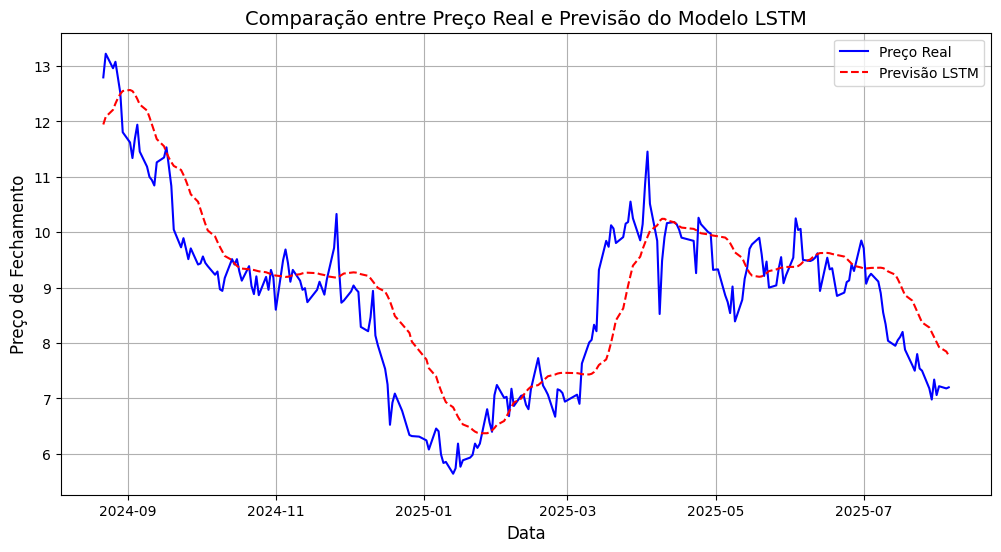

In [55]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_predictions.index, df_predictions["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_predictions.index, df_predictions["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [56]:
# Calcular média de acertos e expectativa de lucro
df_predictions = df_predictions.copy()

df_predictions['Variação percentual real'] = df_predictions['Real'].pct_change()

#Nova coluna com a variação percentual da ação prevista
df_predictions['Variação percentual previsão'] = df_predictions['Previsão'].pct_change()

#Remover valores nulos
df_predictions = df_predictions.dropna()

#Nova coluna com a informação se a ação subiu ou não
df_predictions['Ação subiu'] = np.where(df_predictions['Variação percentual real'] > 0, 
                                                      True, False)

#Nova coluna com a informação se a previsão subiu ou não
df_predictions['Previsão subiu'] = np.where(df_predictions['Variação percentual previsão'] > 0, 
                                                      True, False)

#Nova coluna com a informação se o modelo acertou a tendência
df_predictions['Modelo acertou tendência'] = np.where(df_predictions['Ação subiu'] == df_predictions['Previsão subiu']
                                      , True, False)

#Nova coluna com a variação percentual real absoluta
df_predictions['Variação percentual real absoluto'] = df_predictions['Variação percentual real'].abs()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_predictions['Modelo acertou tendência'].sum()/len(df_predictions['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_predictions.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular media de acertos e expectativa de lucro
acertou_lado = df_predictions['Modelo acertou tendência'].sum()/len(df_predictions['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_predictions.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular expectativa matematica de lucro
exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

#calcular ganho sobre perda
ganho_sobre_perda = media_lucro[1]/media_lucro[0]

#calcular rendimento diario
exp_mat_lucro_percent = exp_mat_lucro * 100

print(f"Media lucro: {media_lucro}")
print(f"Ganho sobre perda: {ganho_sobre_perda}")
print(f"Acertou lado: {acertou_lado}")
print("rendimento diário: " + str(round(exp_mat_lucro_percent, 4)) + "%")


Media lucro: Modelo acertou tendência
False    0.032281
True     0.031223
Name: Variação percentual real absoluto, dtype: float64
Ganho sobre perda: 0.9672168416913544
Acertou lado: 0.538135593220339
rendimento diário: 0.1893%


C:\Users\pedro\AppData\Local\Temp\ipykernel_29576\3448409587.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
C:\Users\pedro\AppData\Local\Temp\ipykernel_29576\3448409587.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganho_sobre_perda = media_lucro[1]/media_lucro[0]


In [57]:
# Define o intervalo de datas com base no horário atual
hoje = datetime.now()

if hoje.hour > 18:
    data_final = hoje
    texto_previsao = "\nPreço de fechamento previsto para amanhã:"
else:
    data_final = hoje - timedelta(days=1)
    texto_previsao = "\nPreço de fechamento previsto para hoje:"

data_inicial = hoje - timedelta(days=252)

# Baixa as cotações da ação no intervalo
cotacoes = yf.download(acao, start=data_inicial, end=data_final)

# Seleciona os últimos 60 dias de fechamento e normaliza
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)
ultimos_60_dias_df = pd.DataFrame(ultimos_60_dias, columns=scaler.feature_names_in_)
ultimos_60_dias_scaled = scaler.transform(ultimos_60_dias_df)

# Prepara os dados para o modelo
X_input = np.array([ultimos_60_dias_scaled])
X_input = X_input.reshape(X_input.shape[0], X_input.shape[1], 1)

# Faz a previsão e reverte a escala
predicted_price = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price)

# Mostra o resultado
print(texto_previsao)
print(f"R$ {predicted_price[0][0]:.2f}")


C:\Users\pedro\AppData\Local\Temp\ipykernel_29576\1141091753.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cotacoes = yf.download(acao, start=data_inicial, end=data_final)
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

Preço de fechamento previsto para hoje:
R$ 7.77


In [59]:
import pandas as pd
from datetime import timedelta

# Define o número de dias para exibir
dias_passados = 4
dias_futuros = 1

# Garante que o DataFrame de previsões está com o índice como datetime
df_predictions.index = pd.to_datetime(df_predictions.index)

# Define a data final (último dia disponível)
data_final = df_predictions.index.max()

# Define o intervalo de datas: do passado até o futuro
data_inicial = data_final - timedelta(days=dias_passados)
data_futura = data_final + timedelta(days=dias_futuros)

# Filtra o DataFrame para o intervalo desejado e apenas as colunas 'Real' e 'Previsão'
df_resultado = df_predictions.loc[data_inicial:data_futura, ['Real', 'Previsão']].copy()

# Formata os valores para 2 casas decimais
df_resultado['Real'] = df_resultado['Real'].map(lambda x: f"R$ {x:.2f}")
df_resultado['Previsão'] = df_resultado['Previsão'].map(lambda x: f"R$ {x:.2f}")

# Renomeia as colunas
df_resultado.columns = ['Preço Real', 'Preço Estimado']

# Exibe o resultado
print("📊 Comparativo de Preço Real vs Estimado:\n")
display(df_resultado)


📊 Comparativo de Preço Real vs Estimado:



,Preço Real,Preço Estimado
Date,,
2025-08-01,R$ 7.22,R$ 7.93
2025-08-04,R$ 7.18,R$ 7.85
2025-08-05,R$ 7.20,R$ 7.77
